# 1 查看数据集

In [1]:
# 使用pandas读取数据集
import pandas as pd
data = pd.read_csv('data\\OCEMOTION.csv', sep='\t',header=None)
# 由于该数据集没有列名，故需要为其添加上列名以便于更好处理
data.columns = ["id", "text_a", "label"]

In [2]:
# 查看数据前5条内容
data.head()

,id,text_a,label
0,0,'你知道多伦多附近有什么吗?哈哈有破布耶.真的书上写的你听哦.你家那块破布是世界上最大的破布...,sadness
1,1,"平安夜,圣诞节,都过了,我很难过,和妈妈吵了两天,以死相逼才终止战争,现在还处于冷战中。",sadness
2,2,"我只是自私了一点,做自己想做的事情!",sadness
3,3,"让感动的不仅仅是雨过天晴,还有泪水流下来的迷人眼神。",happiness
4,4,好日子,happiness


In [3]:
# 查看数据文件信息，可以看出总共有35315条数据
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35694 entries, 0 to 35693
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      35694 non-null  int64 
 1   text_a  35694 non-null  object
 2   label   35694 non-null  object
dtypes: int64(1), object(2)
memory usage: 836.7+ KB


In [4]:
# 统计评论文本长度信息,从平均长度可以看出属于短文本
data['text_a'].map(len).describe()

count    35694.000000
mean        45.440074
std         37.990767
min          2.000000
25%         16.000000
50%         32.000000
75%         64.000000
max        208.000000
Name: text_a, dtype: float64

In [5]:
# 统计数据集中7种情感类别标签的分布情况
data['label'].value_counts()

label
sadness      12604
happiness     8981
disgust       4405
anger         4115
like          4087
surprise       908
fear           594
Name: count, dtype: int64

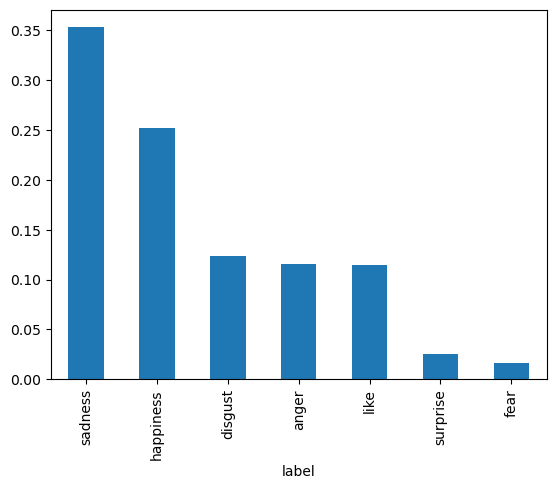

In [7]:
# 可视化标签分布情况
%matplotlib inline
data['label'].value_counts(normalize=True).plot(kind='bar');

# 2 数据清洗
> 清洗字符

> 清洗表情 表情变成中文

In [8]:
# 导入所需包
import re
import os
import shutil
from tqdm import tqdm
from collections import defaultdict

# 定义数据清洗函数:

# 清洗分隔字符
def clean_duplication(text):
    left_square_brackets_pat = re.compile(r'\[+')
    right_square_brackets_pat = re.compile(r'\]+')
    punct = [',', '\\.', '\\!', '，', '。', '！', '、', '\?', '？']

    def replace(string, char):
        pattern = char + '{2,}'
        if char.startswith('\\'):
            char = char[1:]
        string = re.sub(pattern, char, string)
        return string

    text = left_square_brackets_pat.sub('', text)
    text = right_square_brackets_pat.sub('', text)
    for p in punct:
        text = replace(text, p)
    return text

def emoji2zh(text, inverse_emoji_dict):
    for emoji, ch in inverse_emoji_dict.items():
        text = text.replace(emoji, ch)
    return text

# 清洗数据集中特殊表情，通过json文件的映射用中文替代表情
def clean_emotion(data_path, emoji2zh_data, save_dir, train=True):
    data = defaultdict(list)
    filename = os.path.basename(data_path)
    with open(data_path, 'r', encoding='utf8') as f:
        texts = f.readlines()
        for line in tqdm(texts, desc=data_path):
            if train:
                id_, text, label = line.strip().split('\t')
            else:
                id_, text = line.strip().split('\t')
            data['id'].append(id_)
            text = emoji2zh(text, emoji2zh_data)
            text = clean_duplication(text)
            data['text_a'].append(text)
            if train:
                data['label'].append(label)
    df = pd.DataFrame(data)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    df.to_csv(os.path.join(save_dir, filename), index=False,
              encoding='utf8', header=False, sep='\t')
    return df

In [9]:
# 读取表情映射json文件（放在work目录下，文件名为emoji2zh.json），用于替换表情为中文字符
import json
emoji2zh_data = json.load(open('work\\emoji2zh.json', 'r', encoding='utf8'))

In [10]:
# 对数据进行数据清洗
data = clean_emotion('data\\OCEMOTION.csv',emoji2zh_data,'./')

data\OCEMOTION.csv: 100%|██████████| 35694/35694 [00:02<00:00, 17173.51it/s]


In [11]:
data

,id,text_a,label
0,0,'你知道多伦多附近有什么吗?哈哈有破布耶.真的书上写的你听哦.你家那块破布是世界上最大的破布...,sadness
1,1,"平安夜,圣诞节,都过了,我很难过,和妈妈吵了两天,以死相逼才终止战争,现在还处于冷战中。",sadness
2,2,"我只是自私了一点,做自己想做的事情!",sadness
3,3,"让感动的不仅仅是雨过天晴,还有泪水流下来的迷人眼神。",happiness
4,4,好日子,happiness
...,...,...,...
35689,35689,跟两位好友吃了一顿手包饺子九菜味煎的食得好饱馋嘴【能吃到饱的感觉真幸福满足,happiness
35690,35690,"你只看到我的旧坑,却没看到我又开了新坑;你有你的规则,我有我的潜规则;你否定bg,我决定必基...",happiness
35691,35691,"欠你的,伤你的,还有机会补偿吗?",sadness
35692,35692,"昨天晚上失眠啊,失了一晚上啊,早上要睡着结果要上班了。今天上午还开一上午的会,来不起了啊。泪",sadness


In [12]:
# 去掉无用的id列，保存其格式为text_a,label
data = data[['text_a', 'label']]

In [13]:
data

,text_a,label
0,'你知道多伦多附近有什么吗?哈哈有破布耶.真的书上写的你听哦.你家那块破布是世界上最大的破布...,sadness
1,"平安夜,圣诞节,都过了,我很难过,和妈妈吵了两天,以死相逼才终止战争,现在还处于冷战中。",sadness
2,"我只是自私了一点,做自己想做的事情!",sadness
3,"让感动的不仅仅是雨过天晴,还有泪水流下来的迷人眼神。",happiness
4,好日子,happiness
...,...,...
35689,跟两位好友吃了一顿手包饺子九菜味煎的食得好饱馋嘴【能吃到饱的感觉真幸福满足,happiness
35690,"你只看到我的旧坑,却没看到我又开了新坑;你有你的规则,我有我的潜规则;你否定bg,我决定必基...",happiness
35691,"欠你的,伤你的,还有机会补偿吗?",sadness
35692,"昨天晚上失眠啊,失了一晚上啊,早上要睡着结果要上班了。今天上午还开一上午的会,来不起了啊。泪",sadness


# 3 转换情感类别标签
由于类别名为英文，此处主要将英文类别名转为中文类别名，从而更好应用于中文情感分析系统中去！

In [14]:
# 替换数据集中标签,{'sadness': '难过', 'happiness': '愉快', 'like': '喜欢', 'anger': '愤怒', 'fear': '害怕', 'surprise': '惊讶', 'disgust': '厌恶'}
data.loc[data['label']=='sadness', 'label'] = '难过'
data.loc[data['label']=='happiness', 'label'] = '愉快'
data.loc[data['label']=='like', 'label'] = '喜欢'
data.loc[data['label']=='anger', 'label'] = '愤怒'
data.loc[data['label']=='fear', 'label'] = '害怕'
data.loc[data['label']=='surprise', 'label'] = '惊讶'
data.loc[data['label']=='disgust', 'label'] = '厌恶'

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11696\3800690894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['label']=='sadness', 'label'] = '难过'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_11696\3800690894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['label']=='happiness', 'label'] = '愉快'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_11696\3800690894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

# 4 手动划分训练、验证和测试集

划分训练、验证和测试集原因：

a)训练集直接参与了模型调参的过程，显然不能用来反映模型真实的能力（防止课本死记硬背的学生拥有最好的成绩，即防止过拟合)。

b)验证集参与了人工调参(超参数)的过程，也不能用来最终评判一个模型（刷题库的学生不能算是学习好的学生）。

c) 所以要通过最终的考试(测试集)来考察一个学(模)生(型)真正的能力（期末考试）。

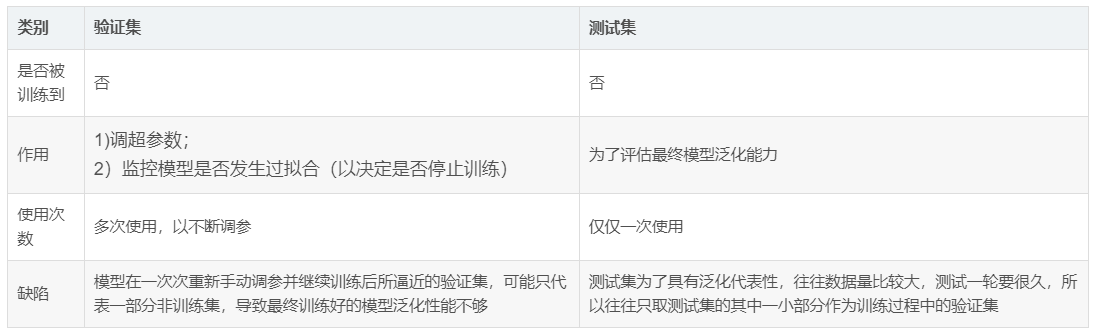

In [ ]:
# # 划分方式1：根据比例直接划分训练、验证和测试集
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2)
train_data,valid_data=train_test_split(train_data, test_size=0.2)

# 对数据进行随机打乱
from sklearn.utils import shuffle
train_data = shuffle(train_data)
valid_data = shuffle(valid_data)
test_data = shuffle(test_data)

# 保存划分好的数据集文件
train_data.to_csv('./train.csv', index=False, sep="\t") # 训练集
valid_data.to_csv('./valid.csv', index=False, sep="\t")  # 验证集
test_data.to_csv('./test.csv', index=False, sep="\t")   # 测试集

print('训练集长度：', len(train_data), '验证集长度：', len(valid_data), '测试集长度', len(test_data))

训练集长度： 22844 验证集长度： 5711 测试集长度 7139


In [ ]:
# # 划分方式2：根据具体类别按8：1：1去划分训练、验证和测试集,这样可以使得数据尽量同分布

# from sklearn.utils import shuffle
# train = pd.DataFrame()  # 训练集
# valid = pd.DataFrame()  # 验证集
# test = pd.DataFrame()  # 测试集

# tags = data['label'].unique().tolist()  # 按照该标签进行等比例抽取

# # 根据数据集的类别按8:1:1的比例划分训练、验证和测试集并随机打乱后保存
# for tag in tags:
#     # 随机选取0.2的数据作为训练和验证集
#     target = data[(data['label'] == tag)]
#     sample = target.sample(int(0.2 * len(target)))
#     sample_index = sample.index
#     # 将剩余0.8的数据作为训练集
#     all_index = target.index
#     residue_index = all_index.difference(sample_index)  # 去除sample之后剩余的数据
#     residue = target.loc[residue_index]
#     # 对划分出来的0.2的数据集按等比例进行测试集和验证集的划分
#     test_sample = sample.sample(int(0.5 * len(sample)))
#     test_sample_index = test_sample.index
#     valid_sample_index = sample_index.difference(test_sample_index)
#     valid_sample = sample.loc[valid_sample_index]
#     # 拼接各个类别
#     test = pd.concat([test, test_sample], ignore_index=True)
#     valid = pd.concat([valid, valid_sample], ignore_index=True)
#     train = pd.concat([train, residue], ignore_index=True)
#     # 对数据进行随机打乱
#     train = shuffle(train)
#     valid = shuffle(valid)
#     test = shuffle(test)

# # 保存为tab分隔的文本
# train.to_csv('train.csv', sep='\t', index=False)  # 训练集
# valid.to_csv('valid.csv', sep='\t', index=False)  # 验证集
# test.to_csv('test.csv', sep='\t', index=False)    # 测试集

# print('训练集长度：', len(train), '验证集长度：', len(valid), '测试集长度', len(test))

ModuleNotFoundError: No module named 'sklearn'

# 5 基于PaddleHub构建微情感分析模型

In [19]:
# 下载最新版本的paddlehub
!pip install -U paddlehub -i https://pypi.tuna.tsinghua.edu.cn/simple

^C


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
      --------------------------------------- 0.8/39.5 MB 5.6 MB/s eta 0:00:07
     -- ------------------------------------- 2.4/39.5 MB 7.1 MB/s eta 0:00:06
     ---- ----------------------------------- 4.7/39.5 MB 8.9 MB/s eta 0:00:04
     ---------- ---------------------------- 11.0/39.5 MB 15.6 MB/s eta 0:00:02
     ------------------ -------------------- 18.6/39.5 MB 19.9 MB/s eta 0:00:02
     ------------------------ -------------- 24.6/39.5 MB 21.4 MB/s eta 0:00:01
     ------------------------------ -------- 30.7/39.5 MB 22.6 MB/s eta 0:00:01
     ----------------------------------- --- 35.9/39.5 MB 22.8 MB/s eta 0:00:01
     --------------------------------------- 39.5/39.5 MB 22.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
     ---------------------------------------- 1.8/1.8 MB 19.9 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
paddlepaddle-gpu 3.0.0rc1 requires nvidia-cublas-cu11==11.11.3.6, which is not installed.
paddlepaddle-gpu 3.0.0rc1 requires nvidia-cuda-runtime-cu11==11.8.89, which is not installed.
paddlepaddle-gpu 3.0.0rc1 requires nvidia-cudnn-cu11==8.9.4.19, which is not installed.
paddlepaddle-gpu 3.0.0rc1 requires nvidia-cufft-cu11==10.9.0.58, which is not installed.
paddlepaddle-gpu 3.0.0rc1 requires nvidia-curand-cu11==10.3.0.86, which is not installed.
paddlepaddle-gpu 3.0.0rc1 requires nvidia-cusolver-cu11==11.4.1.48, which is not installed.
paddlepaddle-gpu 3.0.0rc1 requires nvidia-cusparse-cu11==11.7.5.86, which is not installed.


In [20]:
# 导入paddlehub和paddle包
import paddlehub as hub
import paddle

d:\anaconda\envs\motion_py311\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
d:\anaconda\envs\motion_py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\anaconda\envs\motion_py311\Lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


## 5.1 加载预训练模型-ERNIE Tiny

In [21]:

# 设置要求进行分类的7个情感类别
label_list=list(data.label.unique())
print(label_list)

label_map = { 
    idx: label_text for idx, label_text in enumerate(label_list)
}
print(label_map)

['难过', '愉快', '喜欢', '愤怒', '害怕', '惊讶', '厌恶']
{0: '难过', 1: '愉快', 2: '喜欢', 3: '愤怒', 4: '害怕', 5: '惊讶', 6: '厌恶'}


In [22]:

# 只需指定想要使用的模型名称和文本分类的类别数即可完成Fine-tune网络定义，在预训练模型后拼接上一个全连接网络（Full Connected）进行分类
# 此处选择ernie_tiny预训练模型并设置微调任务为7分类任务
model = hub.Module(name="ernie_tiny", task='seq-cls', num_classes=7, label_map=label_map)

Download https://bj.bcebos.com/paddlehub/paddlehub_dev/ernie_tiny.zip
[##################################################] 100.00%
Decompress C:\Users\ASUS\.paddlehub\tmp\tmpwqsnemtz\ernie_tiny.zip
[##################################################] 100.00%

[2025-03-24 16:18:41,398] [    INFO] - Successfully installed ernie_tiny-2.0.2


[2025-03-24 16:18:41,401] [    INFO] - Configuration saved in C:\Users\ASUS\.paddlenlp\models\ernie-tiny\config.json
[2025-03-24 16:18:41,705] [    INFO] - Downloading https://bj.bcebos.com/paddlenlp/models/transformers/ernie_tiny/ernie_tiny.pdparams
[2025-03-24 16:18:41,707] [    INFO] - Downloading ernie_tiny.pdparams from https://bj.bcebos.com/paddlenlp/models/transformers/ernie_tiny/ernie_tiny.pdparams
100%|██████████| 346M/346M [00:45<00:00, 8.00MB/s] 
[2025-03-24 16:19:27,848] [    INFO] - Loading weights file model_state.pdparams from cache at C:\Users\ASUS\.paddlenlp\models\ernie-tiny\model_state.pdparams
[2025-03-24 16:19:28,091] [    INFO] - Loaded weights file from disk, setting weights to model.
[2025-03-24 16:19:28,761] [    INFO] - All model checkpoint weights were used when initializing ErnieForSequenceClassification.

[2025-03-24 16:19:28,761] [ WARNING] - Some weights of ErnieForSequenceClassification were not initialized from the model checkpoint at ernie-tiny and are

hub.Module的参数用法如下：

name：模型名称，可以选择ernie，ernie_tiny，bert-base-cased， bert-base-chinese, roberta-wwm-ext，roberta-wwm-ext-large等。
task：fine-tune任务。此处为seq-cls，表示文本分类任务。
num_classes：表示当前文本分类任务的类别数，根据具体使用的数据集确定，默认为2，需要根据具体分类任务进行选定。

在飞桨（PaddlePaddle）的PaddleHub框架中，Fine-tune网络指的是在预训练模型基础上添加的、用于适配具体下游任务的可训练网络层。在您提供的代码示例中，hub.Module通过task='seq-cls'参数自动构建了一个面向序列分类任务的微调网络。

当您调用hub.Module并指定task='seq-cls'时，系统会自动构建以下结构：输入文本 → 预训练模型（如Ernie-tiny） → 特征向量（Pooled Output） → 全连接分类层（FC Layer） → 7分类输出


> 意思就是说这里会自动构建 不需要我们搭建基础模型

> 国产深度学习框架还是🐂

## 5.2 加载并处理数据

In [23]:
# 导入依赖库
import os, io, csv
from paddlehub.datasets.base_nlp_dataset import InputExample, TextClassificationDataset

In [29]:

# 数据集存放位置
DATA_DIR=""

In [30]:
# 对数据进行处理，处理为模型可接受的格式
'''
    参数说明：
        tokenizer：预训练模型对应的分词器（如ErnieTokenizer），用于将文本转为ID序列。
        mode：数据集模式，决定加载哪个文件（train/test/valid）。
        max_seq_len：最大序列长度，超过此长度的文本会被截断。
'''
class OCEMOTION(TextClassificationDataset):
    def __init__(self, tokenizer, mode='train', max_seq_len=128):
        if mode == 'train':
            data_file = 'train.csv'  # 训练集
        elif mode == 'test':
            data_file = 'test.csv'   # 测试集
        else:
            data_file = 'valid.csv'  # 验证集
        
        super(OCEMOTION, self).__init__(
            base_path=DATA_DIR,
            data_file=data_file,
            tokenizer=tokenizer,
            max_seq_len=max_seq_len,
            mode=mode,
            is_file_with_header=True,
            label_list=label_list
            )
    '''
    基类初始化：调用父类构造方法，传递关键参数：
        base_path：数据集根目录路径（需提前定义DATA_DIR变量）。
        is_file_with_header：数据文件是否包含标题行（True表示第一行是列名）。
        label_list：所有可能的标签列表（如['sadness', 'happiness', ...]）。
    '''
    # 解析文本文件里的样本
    def _read_file(self, input_file, is_file_with_header: bool = False):
        if not os.path.exists(input_file):
            raise RuntimeError("The file {} is not found.".format(input_file))
        else:
            with io.open(input_file, "r", encoding="UTF-8") as f:
                reader = csv.reader(f, delimiter="\t")
                examples = []
                seq_id = 0
                header = next(reader) if is_file_with_header else None
                for line in reader:
                    try:
                        example = InputExample(guid=seq_id, text_a=line[0], label=line[1])
                        seq_id += 1
                        examples.append(example)
                    except:
                        continue
                return examples
    '''
    关键步骤：
        1.文件存在性检查：确保数据文件路径有效。
        2.打开文件：使用UTF-8编码读取，避免中文乱码。
        3.CSV解析：假设数据格式为文本\t标签（例如："今天很开心\thappiness"）。
        4.跳过标题行：当is_file_with_header=True时，用next(reader)跳过首行。
        5.构建样本对象：
            InputExample是PaddleHub定义的样本类，包含：
            guid：唯一标识符（此处用自增ID）。
            text_a：输入文本（对应line[0]）。
            label：标签值（对应line[1]）。
        6. 异常处理：遇到格式错误的行（如列数不足）时跳过。
    '''  
# 数据集实例化
'''
参数传递：
    model.get_tokenizer()：获取预训练模型对应的分词器（如ErnieTokenizer）。
    max_seq_len=128：设定序列最大长度为128（ERNIE模型最大支持512）。
实际处理流程（由基类完成）：
    分词：将文本转为token IDs（例如："你好" → [101, 872, 1962, 102]）。
    序列填充/截断：长度不足128的补0，超过的截断。
    生成Attention Mask：标识哪些位置是有效token。
    标签映射：将字符串标签转为数字索引（如'happiness' → 1）。
'''
train_dataset = OCEMOTION(model.get_tokenizer(), mode='train', max_seq_len=128)  # max_seq_len根据具体文本长度进行确定，但需注意max_seq_len最长不超过512
dev_dataset = OCEMOTION(model.get_tokenizer(), mode='dev', max_seq_len=128)
test_dataset = OCEMOTION(model.get_tokenizer(), mode='test', max_seq_len=128)
# 预览数据
# 查看训练集前3条
for e in train_dataset.examples[:3]:
    print(e)
# 查看验证集前3条
for e in dev_dataset.examples[:3]:
    print(e)
# 查看测试集前3条
for e in test_dataset.examples[:3]:
    print(e)

[2025-03-24 16:26:44,733] [    INFO] - Already cached C:\Users\ASUS\.paddlenlp\models\ernie-tiny\vocab.txt
[2025-03-24 16:26:44,734] [    INFO] - Already cached C:\Users\ASUS\.paddlenlp\models\ernie-tiny\spm_cased_simp_sampled.model
[2025-03-24 16:26:44,734] [    INFO] - Already cached C:\Users\ASUS\.paddlenlp\models\ernie-tiny\dict.wordseg.pickle
[2025-03-24 16:26:47,397] [    INFO] - tokenizer config file saved in C:\Users\ASUS\.paddlenlp\models\ernie-tiny\tokenizer_config.json
[2025-03-24 16:26:47,399] [    INFO] - Special tokens file saved in C:\Users\ASUS\.paddlenlp\models\ernie-tiny\special_tokens_map.json
d:\anaconda\envs\motion_py311\Lib\site-packages\paddlenlp\transformers\tokenizer_utils_base.py:2293: FutureWarning: The `max_seq_len` argument is deprecated and will be removed in a future version, please use `max_length` instead.
  warnings.warn(
d:\anaconda\envs\motion_py311\Lib\site-packages\paddlenlp\transformers\tokenizer_utils_base.py:1865: UserWarning: Truncation was not

text=今天体侧我累到喊小敏,小敏,小敏,等我啊~~~,哈哈,跑完后全身冰凉,但是好开心,跑完啦终于,拖着疲惫的身躯还不忘了来一瓶红牛,仿佛喝了才安心,虽然不喜欢跑步,但是以后会督促自己多运动的~~抱抱酷	label=愉快
text=为什么我爱的人不爱我,我不爱的人不理我呢!你们快砰砰理啊!	label=难过
text=那么多的事。那么多的人。都好无奈。无能为力。	label=难过
text=头真晕	label=愤怒
text=听陈医生的稳稳的幸福,总觉得幸福是一件安安静静的事情,是一件简简单单的事情,是发生在每一个人身上的故事!	label=愉快
text=我还不够勇敢~去坚持我自己喜欢做的事	label=难过
text=大哥我只不过失手没把你打屎你就一口气在我一条小腿上啃五下尼玛大哥你嘴还那么大太不够意思了吧大哥	label=愤怒
text=不是我想一个人的,只是现实就这样!鄙视鄙视	label=难过
text=娘让我带回家一瓶“飘柔”来,去买的时候,小姑娘一直憋笑,看的难受,就说:大声笑吧,别憋坏了,秃子的心胸都像头顶一样光芒万丈普照世人。小姑娘大笑:哥,你真逗。然后,送了我一个孩子用的水瓶。这算关怀残障人士吗?	label=愉快


## 5.3 选择优化策略和运行配置

In [31]:
# 优化器的选择，此处使用了AdamW优化器
optimizer = paddle.optimizer.AdamW(learning_rate=4e-5, parameters=model.parameters())

In [32]:
# 运行配置
trainer = hub.Trainer(model, optimizer, checkpoint_dir='./ckpt', use_gpu=True, use_vdl=True)      # fine-tune任务的执行者

[2025-03-24 16:28:03,395] [ WARNING] - PaddleHub model checkpoint not found, start from scratch...


Trainer 主要控制Fine-tune任务的训练，是任务的发起者，包含以下可控制的参数:

model: 被优化模型；
optimizer: 优化器选择；
use_gpu: 是否使用gpu训练；
use_vdl: 是否使用vdl可视化训练过程；
checkpoint_dir: 保存模型参数的地址；
compare_metrics: 保存最优模型的衡量指标；

## 5.4 模型训练和验证

In [33]:
trainer.train(train_dataset, epochs=5, batch_size=256, eval_dataset=dev_dataset, save_interval=1)   # 配置训练参数，启动训练，并指定验证集。

[2025-03-24 16:32:07,606] [   TRAIN] - Epoch=1/5, Step=10/90 loss=1.6665 acc=0.3578 lr=0.000040 step/sec=0.19 | ETA 00:39:47
[2025-03-24 16:32:50,472] [   TRAIN] - Epoch=1/5, Step=20/90 loss=1.4778 acc=0.4434 lr=0.000040 step/sec=0.23 | ETA 00:35:58
[2025-03-24 16:33:29,877] [   TRAIN] - Epoch=1/5, Step=30/90 loss=1.3723 acc=0.4906 lr=0.000040 step/sec=0.25 | ETA 00:33:49
[2025-03-24 16:34:09,374] [   TRAIN] - Epoch=1/5, Step=40/90 loss=1.2747 acc=0.5273 lr=0.000040 step/sec=0.25 | ETA 00:32:46
[2025-03-24 16:34:50,178] [   TRAIN] - Epoch=1/5, Step=50/90 loss=1.2523 acc=0.5352 lr=0.000040 step/sec=0.25 | ETA 00:32:20
[2025-03-24 16:35:31,005] [   TRAIN] - Epoch=1/5, Step=60/90 loss=1.2327 acc=0.5449 lr=0.000040 step/sec=0.24 | ETA 00:32:03
[2025-03-24 16:36:11,301] [   TRAIN] - Epoch=1/5, Step=70/90 loss=1.1717 acc=0.5699 lr=0.000040 step/sec=0.25 | ETA 00:31:47
[2025-03-24 16:36:52,894] [   TRAIN] - Epoch=1/5, Step=80/90 loss=1.1971 acc=0.5535 lr=0.000040 step/sec=0.24 | ETA 00:31:43


trainer.train 主要控制具体的训练过程，包含以下可控制的参数：

train_dataset: 训练时所用的数据集；
epochs: 训练轮数；
batch_size: 训练的批大小，如果使用GPU，请根据实际情况调整batch_size；
num_workers: works的数量，默认为0；
eval_dataset: 验证集；
log_interval: 打印日志的间隔， 单位为执行批训练的次数。
save_interval: 保存模型的间隔频次，单位为执行训练的轮数。

## 5.5 在测试集上评估当前训练模型

In [34]:
# 在测试集上评估当前训练模型
result = trainer.evaluate(test_dataset, batch_size=128) 

[2025-03-24 17:13:19,126] [    EVAL] - [Evaluation result] avg_acc=0.5770m


In [35]:

# 进阶扩展： 使用F1-score指标对测试集上效果进行更官方的评测
import numpy as np
# 读取测试集文件
df = pd.read_csv('./test.csv',sep = '\t')

news1 = pd.DataFrame(columns=['label'])
news1['label'] = df["label"]
news = pd.DataFrame(columns=['text_a'])
news['text_a'] = df["text_a"]

# 首先将pandas读取的数据转化为array
data_array = np.array(news)
# 然后转化为list形式
data_list =data_array.tolist()

# 对测试集进行预测得到预测的类别标签
y_pre = model.predict(data_list, max_seq_len=128, batch_size=128, use_gpu=True)

# 测试集的真实类别标签
data_array1 = np.array(news1)
y_val =data_array1.tolist()

# 计算预测结果的F1-score
from sklearn.metrics import precision_recall_fscore_support,f1_score,precision_score,recall_score
f1 = f1_score(y_val, y_pre, average='macro')
p = precision_score(y_val, y_pre, average='macro')
r = recall_score(y_val, y_pre, average='macro')
print(f1, p, r)

[2025-03-24 17:13:26,725] [    INFO] - Already cached C:\Users\ASUS\.paddlenlp\models\ernie-tiny\vocab.txt
[2025-03-24 17:13:26,726] [    INFO] - Already cached C:\Users\ASUS\.paddlenlp\models\ernie-tiny\spm_cased_simp_sampled.model
[2025-03-24 17:13:26,727] [    INFO] - Already cached C:\Users\ASUS\.paddlenlp\models\ernie-tiny\dict.wordseg.pickle
[2025-03-24 17:13:29,537] [    INFO] - tokenizer config file saved in C:\Users\ASUS\.paddlenlp\models\ernie-tiny\tokenizer_config.json
[2025-03-24 17:13:29,538] [    INFO] - Special tokens file saved in C:\Users\ASUS\.paddlenlp\models\ernie-tiny\special_tokens_map.json
d:\anaconda\envs\motion_py311\Lib\site-packages\paddlenlp\transformers\tokenizer_utils_base.py:2293: FutureWarning: The `max_seq_len` argument is deprecated and will be removed in a future version, please use `max_length` instead.
  warnings.warn(
d:\anaconda\envs\motion_py311\Lib\site-packages\paddlenlp\transformers\tokenizer_utils_base.py:1865: UserWarning: Truncation was not

0.4859617669967739 0.5278761375492939 0.4676521187022796


## 5.6 模型预测

In [36]:
# 要进行预测的数据
data = [
    # 难过
    ["你也不用说对不起,只是若相惜"],
    # 愉快
    ["幸福其实很简单"],
    # 害怕
    ["恐惧感啊。生病"],
    # 喜欢
    ["待你长发及腰,我们一起耕耘时光。我愿等待"]
]

# 定义要进行情感分类的7个类别
label_list=['难过', '愉快', '喜欢', '愤怒', '害怕', '惊讶', '厌恶']
label_map = {
    idx: label_text for idx, label_text in enumerate(label_list)
}

# 加载训练好的模型
model = hub.Module(
    name='ernie_tiny',
    task='seq-cls',
    num_classes=7,
    load_checkpoint='./ckpt/best_model/model.pdparams',
    label_map=label_map)

# 进行模型预测
results = model.predict(data, max_seq_len=128, batch_size=1, use_gpu=True)
for idx, text in enumerate(data):
    print('Data: {} \t Lable: {}'.format(text[0], results[idx]))

[2025-03-24 17:14:23,377] [    INFO] - Already cached C:\Users\ASUS\.paddlenlp\models\ernie-tiny\model_state.pdparams
[2025-03-24 17:14:23,377] [    INFO] - Loading weights file model_state.pdparams from cache at C:\Users\ASUS\.paddlenlp\models\ernie-tiny\model_state.pdparams
[2025-03-24 17:14:23,741] [    INFO] - Loaded weights file from disk, setting weights to model.
[2025-03-24 17:14:24,248] [    INFO] - All model checkpoint weights were used when initializing ErnieForSequenceClassification.

[2025-03-24 17:14:24,249] [ WARNING] - Some weights of ErnieForSequenceClassification were not initialized from the model checkpoint at ernie-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[2025-03-24 17:14:24,802] [    INFO] - Loaded parameters from d:\vscodeprojects\trysth\motion_classify\ckpt\best_model\model.pdparams
[2025-03-24 17:14:24,807] [    INFO] -

Data: 你也不用说对不起,只是若相惜 	 Lable: 难过
Data: 幸福其实很简单 	 Lable: 愉快
Data: 恐惧感啊。生病 	 Lable: 害怕
Data: 待你长发及腰,我们一起耕耘时光。我愿等待 	 Lable: 喜欢


d:\anaconda\envs\motion_py311\Lib\site-packages\paddlenlp\transformers\tokenizer_utils_base.py:2293: FutureWarning: The `max_seq_len` argument is deprecated and will be removed in a future version, please use `max_length` instead.
  warnings.warn(
d:\anaconda\envs\motion_py311\Lib\site-packages\paddlenlp\transformers\tokenizer_utils_base.py:1865: UserWarning: Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
  warnings.warn(
d:\anaconda\envs\motion_py311\Lib\site-packages\paddlenlp\transformers\tokenizer_utils_base.py:1878: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to

环境导出

In [ ]:
!pipreqs ./ --encoding=utf8 --force
# 不过这个不能用于ipynb

INFO: Not scanning for jupyter notebooks.
INFO: Successfully saved requirements file in ./requirements.txt


In [ ]:
# pip freeze > requirements.txt
# 这个会让当前环境的所有都导出

1.将ipynb变成.py
> 根目录终端输入jupyter nbconvert --to script *.ipynb

2.进行转换
> pipreqs ./ --encoding=utf8 --force